In [ ]:
import math
import random
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:

# =========================
# Global knobs (easy tuning)
# =========================
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# City / motion
R = 20.0                 # half "L1 radius" of diamond region; feasible points satisfy |x|+|y| <= R
V = 1.0                  # speed (distance units per minute)
DT = 0.5                 # minutes per step
HORIZON_MIN = 1440.0      # episode length in minutes (e.g., 4 hours)
STEPS_PER_EP = int(HORIZON_MIN / DT)
# terminal state: all packages delivered


# Demand & revenue
LAMBDA = 0.60            # ride arrival rate per minute (Poisson, spatially uniform over region)
R_PICK_ALPHA = 0.5      # pickup visibility radius parameter r = alpha * R / sqrt(2) (L1-constraint approx)
RT = 8.0                 # per-distance revenue for rides
RP = 1.0                 # revenue per delivered package
REWARD_SCALE = 1.0/8.0
INV_REWARD_SCALE = 1.0/REWARD_SCALE
REPORT_UNSCALED = True
GAMMA_PACK = 0.8        # package spatial intensity (packages per unit area); area = R^2 for diamond in L1 model
RIDE_TTL_MINUTES = 5    # ride request time to live in minutes

# DRL obs/action shaping
MAX_VISIBLE_RIDES = 5    # keep top-K closest pickups
K_NEAREST_PACK = 10      # encode nearest K packages
DISCOUNT = 0.99
PPO_STEPS = 4096
PPO_MINI_BATCH = 256
PPO_EPOCHS = 4
CLIP_EPS = 0.2
VF_COEF = 0.5
ENT_COEF = 0.02
LR = 3e-4
UPDATES = 200
GAE_LAMBDA = 0.95

# Heuristic
SWITCH_GRACE_STEPS = 6



EVAL_EPISODES = 5        # evaluation batch after each update

rng = np.random.default_rng(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# <<< MOD-SEED: per-combo deterministic seeds
def set_global_seeds(seed: int):
    """Reset all RNGs so each combo is reproducible & training path mimics main()."""
    global rng
    rng = np.random.default_rng(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)




In [ ]:

# ==============
# Util functions
# ==============
def manhattan(a: np.ndarray, b: np.ndarray) -> float:
    return float(abs(a[0]-b[0]) + abs(a[1]-b[1]))

def l1_inside(x: float, y: float, r: float) -> bool:
    return abs(x) + abs(y) <= r

def sample_uniform_point_in_diamond(R: float) -> np.ndarray:
    # Rejection sampling in square [-R, R]^2 with L1 constraint
    while True:
        x = rng.uniform(-R, R)
        y = rng.uniform(-R, R)
        if abs(x) + abs(y) <= R:
            return np.array([x, y], dtype=np.float32)

# Normally, it won't go out of the diamond-shaped range. For robustness, 
# if it goes out due to numerical errors at the boundary, it needs to be projected back to the nearest boundary.
def project_to_diamond(p: np.ndarray, R: float) -> np.ndarray:
    # If |x|+|y|>R, project to boundary along direction to origin
    s = abs(p[0]) + abs(p[1])
    if s <= R:
        return p
    if s == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    return p * (R / s)

def step_towards(from_pt: np.ndarray, to_pt: np.ndarray, max_dist: float) -> Tuple[np.ndarray, float, bool]:
    """Move along Manhattan shortest path: first x, then y (or vice versa); return (new_pos, traveled, reached)"""
    x0, y0 = from_pt
    x1, y1 = to_pt
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    d = dx + dy
    if d <= max_dist:
        return to_pt.copy(), d, True
    # Move along x first
    move_x = min(dx, max_dist)
    sign_x = np.sign(x1 - x0)
    x_new = x0 + sign_x * move_x
    remaining = max_dist - move_x
    if remaining > 1e-8:
        move_y = min(dy, remaining)
        sign_y = np.sign(y1 - y0)
        y_new = y0 + sign_y * move_y
    else:
        y_new = y0
    p = np.array([x_new, y_new], dtype=np.float32)
    return p, max_dist, False



In [ ]:

# ========================
# Environment (no zoning)
# ========================
@dataclass
class RideReq:
    pickup: np.ndarray
    dropoff: np.ndarray
    trip_len: float

class CoModalEnv:
    """
    - Region: diamond |x|+|y| <= R (L1 metric)
    - Packages: spatial Poisson with intensity gamma; N ~ Poisson(gamma * R^2), positions IID uniform in diamond
    - Ride arrivals: Poisson(LAMBDA * DT) per step, each with (origin, destination) uniform in diamond
    - Vehicle:
        * cannot deliver packages while carrying passenger (pickup->dropoff)
        * revenue: RP per delivered package; RT * (distance with passenger)
    - Action (discrete): 0 = continue delivering package; i=1..MAX_VISIBLE_RIDES = accept ith visible ride (if available)
      When busy enroute to pickup/dropoff, action is ignored (auto-continue).
    - Observation: vector with normalized features:
        * pos (x/R, y/R), time_frac, flags (to_pickup, with_pass)
        * K nearest packages: for each, (dx/R, dy/R, l1/R)
        * up to K rides visible: for each, (dx_pick/R, dy_pick/R, l1_pick/R, dx_drop/R, dy_drop/R, l1_trip/R)
        * counts: remaining_pkg / (1 + E[N]), current_visible / MAX_VISIBLE_RIDES
      Invalid slots are zero-padded. We also return an action mask for invalid ride indices.
    """
    def __init__(self,
                 R: float = R,
                 v: float = V,
                 dt: float = DT,
                 lam: float = LAMBDA,
                 gamma_pack: float = GAMMA_PACK,
                 rp: float = RP,
                 rt: float = RT,
                 r_pick_alpha: float = R_PICK_ALPHA,
                 ride_ttl_minutes: float=RIDE_TTL_MINUTES, #ride request time to live in minutes
                 max_visible: int = MAX_VISIBLE_RIDES): 
                 
        self.R = R
        self.v = v
        self.dt = dt
        self.lam = lam
        self.gamma = gamma_pack
        self.rp = rp * REWARD_SCALE
        self.rt = rt * REWARD_SCALE
        # max pickup radius (L1) following r = alpha * R / sqrt(2); we keep L1 constraint
        self.r_pick = r_pick_alpha * R / math.sqrt(2.0)

        self.max_visible = int(max_visible)
        self.k_pack = K_NEAREST_PACK
        self.ride_ttl_steps = max(1, int(round(ride_ttl_minutes / self.dt)))
        self._ended_reason: Optional[str] = None
        
        self.reset()

    def reset(self, seed: Optional[int] = None):
        if seed is not None:
            np.random.seed(seed)
        # sample packages
        area = self.R ** 2  # for L1 diamond in the paper
        n_pkg = rng.poisson(self.gamma * area)
        n_pkg = max(1, int(n_pkg))  # ensure non-empty
        self.packages = [sample_uniform_point_in_diamond(self.R) for _ in range(n_pkg)]
        self.packages = np.array(self.packages, dtype=np.float32)

        self.pos = np.array([0.0, 0.0], dtype=np.float32)
        self.t = 0.0
        self.ride_buffer: List[Tuple[RideReq, int]] = []
        self.to_pickup: Optional[np.ndarray] = None
        self.with_passenger: bool = False
        self.drop_target: Optional[np.ndarray] = None

        self.revenue_cum = 0.0
        self._steps = 0
        self._ended_reason = None
        self.accepted_rides = 0
        obs, mask = self._get_obs()
        return obs, mask

    def _append_new_ride(self, reqs: List[RideReq]):
        """Bring the new ride request to this buffer."""
        if not reqs:
            return
        ttl0 = self.ride_ttl_steps
        self.ride_buffer.extend([(r, ttl0) for r in reqs])

    def _sample_rides_this_step(self) -> List[RideReq]:
        k = rng.poisson(self.lam * self.dt)
        reqs = []
        for _ in range(int(k)):
            pk = sample_uniform_point_in_diamond(self.R)
            dp = sample_uniform_point_in_diamond(self.R)
            reqs.append(RideReq(pk, dp, manhattan(pk, dp)))
        return reqs

    def _visible_rides(self) -> List[RideReq]:
        # only show rides with pickup within r_pick (L1) AND we can reach pickup before TTL expires
        visible = []
        for (r, ttl) in self.ride_buffer:
            if ttl <= 0:
                continue
            # 1) Distance filtering: pickup must be within the visible radius
            if manhattan(self.pos, r.pickup) > self.r_pick:
                continue
            # 2) TTL + ETA filtering: must be able to reach pickup within the remaining TTL
            eta_min = manhattan(self.pos, r.pickup) / self.v
            if eta_min <= ttl * self.dt: 
                visible.append(r)
        # Sort by pickup distance and truncate
        visible.sort(key=lambda rr: manhattan(self.pos, rr.pickup))
        return visible[:self.max_visible]


    def _nearest_package(self) -> Optional[np.ndarray]:
        if len(self.packages) == 0:
            return None
        dists = np.abs(self.packages - self.pos).sum(axis=1)
        idx = int(np.argmin(dists))
        return self.packages[idx].copy()


    def _deliver_if_arrived(self):
        if len(self.packages) == 0:
            return 0
        # Deliver packages exactly at current location (robust with small threshold)
        dists = np.abs(self.packages - self.pos).sum(axis=1)
        hit = np.where(dists < 1e-6)[0]
        delivered = len(hit)
        if delivered > 0:
            # deliver all that are exactly here (batch)
            self.revenue_cum += self.rp * delivered
            self.packages = np.delete(self.packages, hit, axis=0)
        return delivered

    def _get_obs(self) -> Tuple[np.ndarray, np.ndarray]:
        # Visible rides & nearest packages
        visible = self._visible_rides()
        # Packages features
        pack_feats = []
        if len(self.packages) > 0:
            d = np.abs(self.packages - self.pos).sum(axis=1)
            order = np.argsort(d)[:self.k_pack]
            for j in order:
                rel = (self.packages[j] - self.pos) / self.R
                pack_feats.extend([rel[0], rel[1], d[j] / self.R])
        # pad
        while len(pack_feats) < 3 * self.k_pack:
            pack_feats.append(0.0)

        ride_feats = []
        for r in visible:
            relp = (r.pickup - self.pos) / self.R
            reld = (r.dropoff - self.pos) / self.R
            ride_feats.extend([relp[0], relp[1], manhattan(self.pos, r.pickup) / self.R,
                               reld[0], reld[1], r.trip_len / self.R])
        while len(ride_feats) < 6 * self.max_visible:
            ride_feats.append(0.0)

        time_frac = self.t / HORIZON_MIN
        flags = [1.0 if self.to_pickup is not None else 0.0,
                 1.0 if self.with_passenger else 0.0]

        counts = [len(self.packages) / (1.0 + self.gamma * (self.R ** 2)),
                  len(visible) / float(self.max_visible)]

        core = [self.pos[0] / self.R, self.pos[1] / self.R, time_frac] + flags + counts
        obs = np.array(core + pack_feats + ride_feats, dtype=np.float32)

        # Action mask: 0 always valid; i>0 valid if i<=len(visible)
        mask = np.zeros(1 + self.max_visible, dtype=np.float32)
        mask[0] = 1.0
        for i in range(len(visible)):
            mask[1 + i] = 1.0
        return obs, mask

    def step(self, action: int):
        reward = 0.0
        done = False
        delivered_step = 0 # track how many packages delivered in this step

        # add fresh arrivals
        self._append_new_ride(self._sample_rides_this_step())

        # If busy towards pickup or with passenger, ignore action (auto-continue)
        if self.to_pickup is not None:
            # move towards pickup
            new_pos, d, reached = step_towards(self.pos, self.to_pickup, self.v * self.dt)
            self.pos = project_to_diamond(new_pos, self.R)
            if reached:
                self.to_pickup = None
                self.with_passenger = True
            # cannot deliver while enroute to pickup
        elif self.with_passenger:
            # move towards dropoff; accrue ride revenue per distance traveled
            new_pos, d, reached = step_towards(self.pos, self.drop_target, self.v * self.dt)
            self.pos = project_to_diamond(new_pos, self.R)
            reward += self.rt * d    # ride distance revenue in this step
            self.revenue_cum += self.rt * d
            if reached:
                self.with_passenger = False
                self.drop_target = None
        else:
            # free: can choose to deliver or accept a visible ride
            visible = self._visible_rides()
            if action > 0 and action <= len(visible):
                chosen = visible[action - 1]
                # remove chosen from buffer
                # (remove by identity)
                for i, (r, ttl) in enumerate(self.ride_buffer):
                    if r is chosen:
                        self.ride_buffer.pop(i)
                        break
                # set pickup/drop targets
                self.to_pickup = chosen.pickup.copy()
                self.drop_target = chosen.dropoff.copy()
                self.accepted_rides += 1
                # move towards pickup immediately this step
                new_pos, d, reached = step_towards(self.pos, self.to_pickup, self.v * self.dt)
                self.pos = project_to_diamond(new_pos, self.R)
                if reached:
                    self.to_pickup = None
                    self.with_passenger = True
            else:
                # deliver: go to nearest package (if any)
                target = self._nearest_package()
                if target is not None:
                    new_pos, d, reached = step_towards(self.pos, target, self.v * self.dt)
                    self.pos = project_to_diamond(new_pos, self.R)
                    if reached:
                        delivered = self._deliver_if_arrived()
                        delivered_step += delivered
                        reward += self.rp * delivered
                # else idle at current location

        # small clean-up: remove stale rides outside pickup radius (we keep buffer but they vanish after 1 step) and TTL Decay
        # simple model: unaccepted rides expire by end of step
        if self.ride_buffer:
            new_buf = []
            for (r, ttl) in self.ride_buffer:
                ttl -= 1
                if ttl > 0:
                    new_buf.append((r, ttl))
            self.ride_buffer = new_buf

        self.t += self.dt
        self._steps += 1

        # Deliver any packages exactly at position (numerical safety)
        if self.to_pickup is None and not self.with_passenger:
            delivered = self._deliver_if_arrived()
            if delivered > 0:
                delivered_step += delivered
                reward += self.rp * delivered
        
        # ---------- termination checks & terminal info ----------
        done_horizon = (self.t >= HORIZON_MIN)
        done_packages = (len(self.packages) == 0) and (not self.with_passenger) and (self.to_pickup is None)
        
        if done_packages or done_horizon:
            done = True
            self._ended_reason = "packages_done" if done_packages else "horizon_reached"
        
        info: Dict[str, object] = {}
        if done:
            info["terminal_time_min"] = float(self.t)
            info["ended_reason"] = self._ended_reason
            info["accepted_rides"] = int(self.accepted_rides)

        info["delivered_step"] = int(delivered_step)
        
        obs, mask = self._get_obs()
        return obs, reward, done, info, mask

    @property
    def obs_dim(self):
        # core (3 + 2 flags + 2 counts) + 3*K + 6*MAX_VISIBLE
        return (3 + 2 + 2) + 3 * self.k_pack + 6 * self.max_visible

    @property
    def act_dim(self):
        return 1 + self.max_visible



In [ ]:

# =================
# Baseline policies
# =================
def run_episode(env: CoModalEnv, policy=None, greedy=False) -> Tuple[float, float, float, str, int]:
    obs, mask = env.reset()
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    for _ in range(STEPS_PER_EP):
        if policy is None:
            # default: deliver-only baseline
            action = 0
        else:
            with torch.no_grad():
                o = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                m = torch.tensor(mask, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                logits, _ = policy(o)
                # mask invalid
                invalid = (m < 0.5)
                logits = logits.masked_fill(invalid, -1e9)
                if greedy:
                    action = int(torch.argmax(logits, dim=-1).item())
                else:
                    probs = torch.softmax(logits, dim=-1)
                    action = int(torch.multinomial(probs, 1).item())
        obs, r, done, info, mask = env.step(action)
        total += r
        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            break
    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = total / terminal_time if terminal_time > 0 else 0.0
    
    return total, terminal_time, revenue_rate, ended_reason, acc


def baseline_nearby_rule(env: CoModalEnv,
                         pickup_alpha=R_PICK_ALPHA,
                         drop_bias=0.5,
                         switch_grace_steps: Optional[int] = None
                         ) -> Tuple[float, float, float, str, int]:
   
    obs, mask = env.reset()
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0

    grace_left = 0

    for _ in range(STEPS_PER_EP):
        visible = env._visible_rides()
        action = 0  # Default: go to the nearest package
        
        gs = SWITCH_GRACE_STEPS if switch_grace_steps is None else int(switch_grace_steps)
        
        #Pre-grace
        # If the nearest package can be delivered in the next step, open the window in advance
        nn = env._nearest_package()
        if nn is not None:
            dist_to_nn = manhattan(env.pos, nn)
            if grace_left == 0 and dist_to_nn <= (env.v * env.dt):
                grace_left = max(1, gs)
                

        if grace_left > 0:
            # Inside the window: as long as there is a qualified order, accept the one with the nearest pickup
            if len(visible) > 0:
                # Accept the one with the nearest pickup
                pk_d_list = [manhattan(env.pos, r.pickup) for r in visible]
                if HEUR_SOFT_PICK_CAP and min(pk_d_list) <= HEUR_SOFT_PICK_CAP:
                    action = 1 + int(np.argmin(pk_d_list))
                    grace_left = 0
                    
                else:
                    action = 1 + int(np.argmin(pk_d_list))
                    grace_left = 0
            else:
                # If there are no qualified orders in the window, decrement the window counter
                grace_left -= 1

        # Execute action
        obs, r, done, info, mask = env.step(action)
        total += r

        delivered_cnt = int(info.get("delivered_this_step", 0))
        if delivered_cnt > 0:
            # After delivering the package: open a new window (including the current and subsequent SWITCH_GRACE_STEPS steps)
            grace_left = max(1, gs)


        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            break

    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = (total / terminal_time) if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc



In [6]:

# ==============
# PPO Components
# ==============
class ActorCritic(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int):
        super().__init__()
        hid = 256
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hid), 
            nn.LayerNorm(hid),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hid, hid), 
            nn.LayerNorm(hid),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.pi = nn.Linear(hid, act_dim)
        self.v  = nn.Linear(hid, 1)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.net(x)
        return self.pi(h), self.v(h)


def ppo_update(policy: ActorCritic, optimizer, batch, clip_eps=CLIP_EPS):
    obs, act, old_logp, ret, adv, mask = batch
    logits, v = policy(obs)
    # mask invalid actions
    invalid = (mask < 0.5)
    logits = logits.masked_fill(invalid, -1e9)
    dist = torch.distributions.Categorical(logits=logits)
    logp = dist.log_prob(act)
    ratio = torch.exp(logp - old_logp)

    clip_adv = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv
    pi_loss = -(torch.min(ratio * adv, clip_adv)).mean()
    v_loss = ((ret - v.squeeze(-1)) ** 2).mean()

    ent = dist.entropy().mean()
    loss = pi_loss + VF_COEF * v_loss - ENT_COEF * ent

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    return pi_loss.item(), v_loss.item(), ent.item(), loss.item()


def collect_rollout(env: CoModalEnv, policy: ActorCritic, steps: int):
    # buffers
    obs_buf, act_buf, rew_buf, val_buf, next_val_buf, logp_buf, mask_buf, done_buf = [], [], [], [], [], [], [], []

    obs, mask = env.reset()
    for _ in range(steps):
        o = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        m = torch.tensor(mask, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            logits, v = policy(o)
            invalid = (m < 0.5)
            logits = logits.masked_fill(invalid, -1e9)
            dist = torch.distributions.Categorical(logits=logits)
            a = dist.sample()
            logp = dist.log_prob(a).squeeze(0)
            v_cur = v.squeeze(0).squeeze(-1)             # V(s_t)

        # step env
        obs2, r, done, _, mask2 = env.step(int(a.item()))

        # compute V(s_{t+1}) for GAE bootstrap
        with torch.no_grad():
            o2 = torch.tensor(obs2, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            _, v_next = policy(o2)
            v_next = v_next.squeeze(0).squeeze(-1)       # V(s_{t+1})

        # store
        obs_buf.append(o.squeeze(0).cpu().numpy())
        mask_buf.append(m.squeeze(0).cpu().numpy())
        act_buf.append(a.cpu().numpy())
        rew_buf.append(r)
        val_buf.append(v_cur.cpu().numpy())
        next_val_buf.append(v_next.cpu().numpy())
        logp_buf.append(logp.cpu().numpy())
        done_buf.append(done)

        obs, mask = obs2, mask2
        if done:
            obs, mask = env.reset()

    # ---------- GAE(λ) advantages & returns ----------
    # arrays
    rewards = np.array(rew_buf, dtype=np.float32)
    values  = np.array(val_buf, dtype=np.float32)
    next_values = np.array(next_val_buf, dtype=np.float32)
    dones   = np.array(done_buf, dtype=np.float32)  # 1.0 if done else 0.0

    advantages = np.zeros_like(rewards, dtype=np.float32)
    gae = 0.0
    gamma = DISCOUNT
    lam = GAE_LAMBDA

    # backward recursion
    for t in reversed(range(len(rewards))):
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * nonterminal - values[t]
        gae = delta + gamma * lam * nonterminal * gae
        advantages[t] = gae

    returns = advantages + values  # target for value head

    # tensors
    obs_t  = torch.tensor(np.array(obs_buf), dtype=torch.float32, device=DEVICE)
    act_t  = torch.tensor(np.array(act_buf).squeeze(-1), dtype=torch.long, device=DEVICE)
    ret_t  = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    adv_t  = torch.tensor(advantages, dtype=torch.float32, device=DEVICE)
    logp_t = torch.tensor(np.array(logp_buf), dtype=torch.float32, device=DEVICE)
    mask_t = torch.tensor(np.array(mask_buf), dtype=torch.float32, device=DEVICE)

    # normalize advantages (keep returns unnormalized)
    adv_t = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

    return obs_t, act_t, logp_t, ret_t, adv_t, mask_t



def make_minibatches(batch, batch_size):
    N = batch[0].shape[0]
    idx = np.arange(N)
    rng.shuffle(idx)
    for i in range(0, N, batch_size):
        j = idx[i:i+batch_size]
        yield tuple(x[j] for x in batch)


In [ ]:
def evaluate_all(env: CoModalEnv, policy: ActorCritic, heur_grace_steps: Optional[int] = None):
    prev_mode = policy.training
    policy.eval()
    try:
        # The collected tuples are still scaled (training-wise)
        drl_eps  = [run_episode(env, policy, greedy=True) for _ in range(EVAL_EPISODES)]
        pure_eps = [run_episode(env, policy=None)        for _ in range(EVAL_EPISODES)]
        heur_eps = [baseline_nearby_rule(env, switch_grace_steps=heur_grace_steps)     for _ in range(EVAL_EPISODES)]

        
        def _descale_eps(eps):
            if not REPORT_UNSCALED:
                return eps
            fixed = []
            for e in eps:
                
                if len(e) == 5:
                    R, T, Rate, reason, acc = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason, acc))
                else: 
                    R, T, Rate, reason = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason))
            return fixed

        drl_out  = _descale_eps(drl_eps)
        pure_out = _descale_eps(pure_eps)
        heur_out = _descale_eps(heur_eps)

        # Aggregate on (possibly) unscaled data, so the printed mean is in the original unit
        def agg(eps):
            R  = np.array([e[0] for e in eps], dtype=float)
            T  = np.array([e[1] for e in eps], dtype=float)
            Rt = np.array([e[2] for e in eps], dtype=float)
            out = dict(avg_reward=R.mean(), avg_t=T.mean(), avg_rate=Rt.mean())
            if len(eps[0]) == 5:
                A  = np.array([e[4] for e in eps], dtype=float)
                out["avg_acc"] = A.mean()
            return out

        # Print per-episode details (presentation-layer-wise)
        def pprint(name, eps):
            print(f"  {name} episodes:")
            if len(eps[0]) == 5:
                for i, (R, T, rate, reason, acc) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, accepted={acc:3d}, reason={reason}{mark}")
            else:
                for i, (R, T, rate, reason) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, reason={reason}{mark}")

        pprint("DRL ", drl_out)
        pprint("HEUR", heur_out)
        pprint("PURE", pure_out)

        return {"drl": agg(drl_out), "heur": agg(heur_out), "pure": agg(pure_out)}
    finally:
        if prev_mode:
            policy.train()


In [8]:

def main():
    env = CoModalEnv()
    policy = ActorCritic(env.obs_dim, env.act_dim).to(DEVICE)
    policy.train()
    optimizer = optim.Adam(policy.parameters(), lr=LR)

    print(f"Device: {DEVICE}, obs_dim={env.obs_dim}, act_dim={env.act_dim}")
    print("Start training PPO...")
    for upd in range(1, UPDATES + 1):
        batch = collect_rollout(env, policy, PPO_STEPS)
        for _ in range(PPO_EPOCHS):
            for mb in make_minibatches(batch, PPO_MINI_BATCH):
                pi_l, v_l, ent, tot = ppo_update(policy, optimizer, mb, CLIP_EPS)
        if upd % 5 == 0:
            metrics = evaluate_all(env, policy)
            drl, heur, pure = metrics["drl"], metrics["heur"], metrics["pure"]
            print(f"[Upd {upd:03d}] "
            f"DRL:  R={drl['avg_reward']:8.2f}, T={drl['avg_t']:7.2f}m, Rate={drl['avg_rate']:6.3f}/m, Acc={drl['avg_acc']:5.2f} | "  # <<< MOD-ACCEPT
            f"HEUR: R={heur['avg_reward']:8.2f}, T={heur['avg_t']:7.2f}m, Rate={heur['avg_rate']:6.3f}/m | "
            f"PURE: R={pure['avg_reward']:8.2f}, T={pure['avg_t']:7.2f}m, Rate={pure['avg_rate']:6.3f}/m "
            f"|| pi={pi_l:.3f} v={v_l:.3f} ent={ent:.3f}")

    # Final evaluation
    metrics = evaluate_all(env, policy)
    drl, heur, pure = metrics["drl"], metrics["heur"], metrics["pure"]
    print("="*80)
    print(f"Final evaluation over {EVAL_EPISODES} eps (<= {HORIZON_MIN:.0f} min each):")
    print(f"  DRL (greedy):        R={drl['avg_reward']:.2f}, T={drl['avg_t']:.2f}m, Rate={drl['avg_rate']:.3f}/m, Acc={drl['avg_acc']:.2f}")  
    print(f"  Nearby heuristic:    R={heur['avg_reward']:.2f}, T={heur['avg_t']:.2f}m, Rate={heur['avg_rate']:.3f}/m")
    print(f"  Pure delivery only:  R={pure['avg_reward']:.2f}, T={pure['avg_t']:.2f}m, Rate={pure['avg_rate']:.3f}/m")


In [9]:
"""
if __name__ == "__main__":
    main()
"""

'\nif __name__ == "__main__":\n    main()\n'

In [ ]:
# =========================
# Grid runner & CSV logger
# =========================


def train_policy_brief(env: CoModalEnv,
                       updates: int,
                       *,
                       eval_every: int = 5,
                       heur_grace_steps: Optional[int] = None):
    """
    Trainer: calls evaluate_all every eval_every updates (consistent with main()), and prints the same style of log.
    Returns (policy, last_metrics)
    """
    policy = ActorCritic(env.obs_dim, env.act_dim).to(DEVICE)
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    policy.train()

    last_metrics = None
    pi_l = v_l = ent = 0.0  # for printing only

    if updates <= 0:
        # No training, just evaluate once as "last_metrics"
        last_metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
        return policy, last_metrics

    for upd in range(1, updates + 1):
        batch = collect_rollout(env, policy, PPO_STEPS)
        for _ in range(PPO_EPOCHS):
            for mb in make_minibatches(batch, PPO_MINI_BATCH):
                pi_l, v_l, ent, tot = ppo_update(policy, optimizer, mb, CLIP_EPS)

        # --- Consistent with main(): evaluate and print every 5 updates --- #
        if eval_every and (upd % eval_every == 0):
            metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
            drl, heur, pure = metrics["drl"], metrics["heur"], metrics["pure"]
            # Align print format with main()
            print(f"[Upd {upd:03d}] "
                  f"DRL:  R={drl['avg_reward']:8.2f}, T={drl['avg_t']:7.2f}m, Rate={drl['avg_rate']:6.3f}/m, Acc={drl.get('avg_acc', float('nan')):5.2f} | "
                  f"HEUR: R={heur['avg_reward']:8.2f}, T={heur['avg_t']:7.2f}m, Rate={heur['avg_rate']:6.3f}/m | "
                  f"PURE: R={pure['avg_reward']:8.2f}, T={pure['avg_t']:7.2f}m, Rate={pure['avg_rate']:6.3f}/m "
                  f"|| pi={pi_l:.3f} v={v_l:.3f} ent={ent:.3f}")
            last_metrics = metrics

    # Add a final evaluation at the end (consistent with main()'s final block)
    if last_metrics is None:
        last_metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
    return policy, last_metrics



def run_param_sweep(
    LAMBDA_list,
    R_PICK_ALPHA_list,
    GAMMA_PACK_list,
    RIDE_TTL_MINUTES_list,
    MAX_VISIBLE_RIDES_list,
    SWITCH_GRACE_STEPS_list,
    *,
    train_updates_per_combo: int = 0,      # Set to 200 for same training intensity as main()
    csv_path: str = "param_sweep_results.csv",
    seed_offset: int = 0                   # Optional: offset seed for parallel/multiple runs
):
    rows = []
    combo_id = 0

    for Lam, Alpha, Gamm, TTL, MV, SGS in itertools.product(
        LAMBDA_list, R_PICK_ALPHA_list, GAMMA_PACK_list,
        RIDE_TTL_MINUTES_list, MAX_VISIBLE_RIDES_list, SWITCH_GRACE_STEPS_list
    ):
        combo_id += 1

        # --- Set a separate seed for each combination to ensure reproducibility and training progress similar to main() --- #
        set_global_seeds(SEED + seed_offset + combo_id) 

        # Construct the environment for this combination (use global for R/V/DT/HORIZON etc.; if you want to sweep them, pass them in)
        env = CoModalEnv(lam=Lam,
                         gamma_pack=Gamm,
                         r_pick_alpha=Alpha,
                         ride_ttl_minutes=TTL,
                         max_visible=MV)

        # Train (including "evaluate and print every 5 updates"), return policy and the last metrics
        policy, metrics = train_policy_brief(env,
                                             updates=train_updates_per_combo,
                                             eval_every=5,
                                             heur_grace_steps=SGS)

        # Write CSV: take the last metrics (presentation-layer unscaled)
        for algo_key in ["drl", "heur", "pure"]:
            m = metrics[algo_key]
            rows.append({
                "combo_id": combo_id,
                "algo": algo_key.upper(),
                "LAMBDA": Lam,
                "R_PICK_ALPHA": Alpha,
                "GAMMA_PACK": Gamm,
                "RIDE_TTL_MIN": TTL,
                "MAX_VISIBLE_RIDES": MV,
                "SWITCH_GRACE_STEPS": SGS,
                "reward": float(m["avg_reward"]),
                "rate":   float(m["avg_rate"]),
                "terminal_time": float(m["avg_t"]),
                "accepted": float(m.get("avg_acc", float('nan')))
            })

    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)
    print(f"[GRID] Wrote {len(df)} rows to {csv_path}")
    return df


In [ ]:
# ==============
# Plot utilities
# ==============
def plot_single_param_trend(df: pd.DataFrame, vary_key: str, metric: str = "rate",
                            algos=("DRL", "HEUR", "PURE"),
                            savepath: Optional[str] = None):
    """
    Plot the trend line of a metric for a single parameter vary_key (other parameters are automatically aggregated by mean).
    """
    # Keep only necessary columns
    cols = ["algo", vary_key, metric]
    tmp = df[cols].dropna()
    # Aggregate: take the mean for the same algo & vary_key
    pivot = (tmp.groupby(["algo", vary_key])[metric]
                .mean()
                .reset_index()
                .pivot(index=vary_key, columns="algo", values=metric)
                .sort_index())
    plt.figure()
    for algo in algos:
        if algo in pivot.columns:
            plt.plot(pivot.index.values, pivot[algo].values, marker="o", label=algo)
    plt.xlabel(vary_key)
    plt.ylabel(metric)
    plt.title(f"{metric} vs {vary_key}")
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


def plot_from_csv(csv_path: str, vary_keys, metrics=("rate", "reward", "accepted")):
    df = pd.read_csv(csv_path)
    for k in vary_keys:
        for m in metrics:
            out = f"plot_{m}_vs_{k}.png"
            plot_single_param_trend(df, k, m, savepath=out)
            print(f"[PLOT] Saved {out}")


  DRL  episodes:
    Ep01: reward=  442.16, terminal_time= 550.00 min, rate= 0.804/min, accepted=  1, reason=packages_done (early-packages-done)
    Ep02: reward=  709.48, terminal_time= 593.50 min, rate= 1.195/min, accepted=  3, reason=packages_done (early-packages-done)
    Ep03: reward=  988.42, terminal_time= 655.00 min, rate= 1.509/min, accepted=  4, reason=packages_done (early-packages-done)
    Ep04: reward=  542.46, terminal_time= 568.50 min, rate= 0.954/min, accepted=  3, reason=packages_done (early-packages-done)
    Ep05: reward= 1134.38, terminal_time= 696.50 min, rate= 1.629/min, accepted=  4, reason=packages_done (early-packages-done)
  HEUR episodes:
    Ep01: reward=  197.00, terminal_time= 494.50 min, rate= 0.398/min, accepted=  0, reason=packages_done (early-packages-done)
    Ep02: reward=  467.98, terminal_time= 605.00 min, rate= 0.774/min, accepted=  1, reason=packages_done (early-packages-done)
    Ep03: reward=  406.29, terminal_time= 555.50 min, rate= 0.731/min,

,combo_id,algo,LAMBDA,R_PICK_ALPHA,GAMMA_PACK,RIDE_TTL_MIN,MAX_VISIBLE_RIDES,SWITCH_GRACE_STEPS,reward,rate,terminal_time,accepted
0,1,DRL,0.4,0.4,0.5,3,5,6,660.736200,1.086973,588.6,3.6
1,1,HEUR,0.4,0.4,0.5,3,5,6,503.308557,0.849166,568.6,1.4
2,1,PURE,0.4,0.4,0.5,3,5,6,205.200000,0.395599,519.0,0.0
3,2,DRL,0.4,0.4,0.5,3,5,12,643.839587,1.058837,592.0,3.0
4,2,HEUR,0.4,0.4,0.5,3,5,12,611.442261,0.994357,595.0,2.6
5,2,PURE,0.4,0.4,0.5,3,5,12,196.800000,0.389616,505.4,0.0
6,3,DRL,0.4,0.4,0.5,3,8,6,783.870068,1.245845,627.6,4.0
7,3,HEUR,0.4,0.4,0.5,3,8,6,406.430829,0.745685,537.3,1.8
8,3,PURE,0.4,0.4,0.5,3,8,6,196.800000,0.378870,519.9,0.0
9,4,DRL,0.4,0.4,0.5,3,8,12,547.591949,0.918004,586.2,2.4


Saved to param_sweep_results.csv


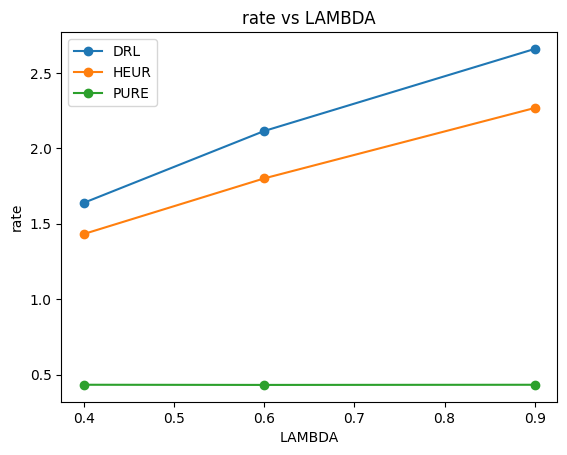

[PLOT] Saved plot_rate_vs_LAMBDA.png


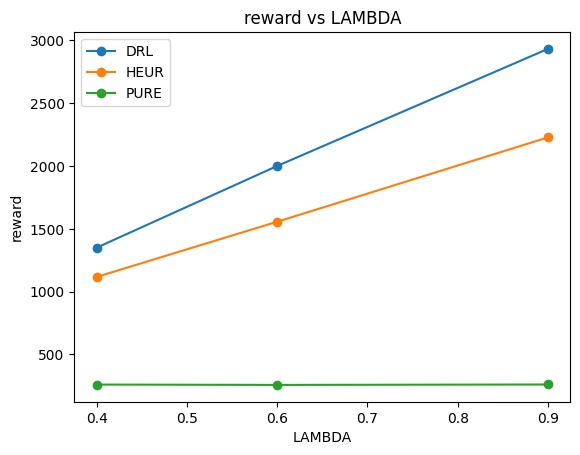

[PLOT] Saved plot_reward_vs_LAMBDA.png


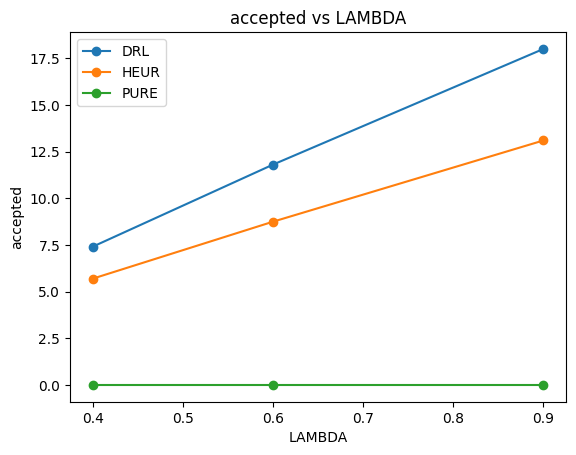

[PLOT] Saved plot_accepted_vs_LAMBDA.png


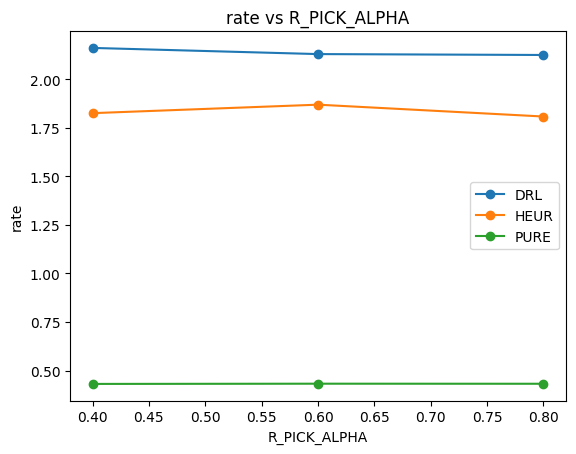

[PLOT] Saved plot_rate_vs_R_PICK_ALPHA.png


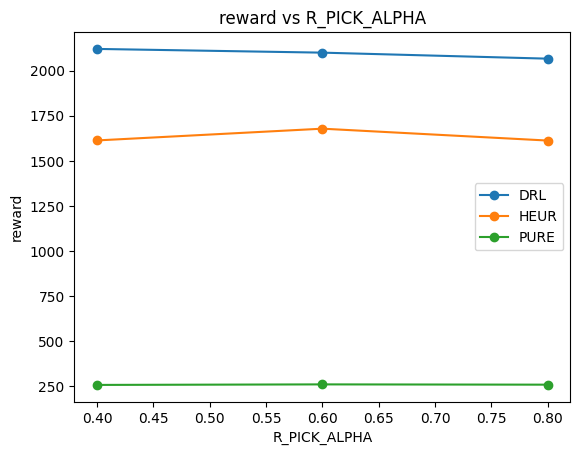

[PLOT] Saved plot_reward_vs_R_PICK_ALPHA.png


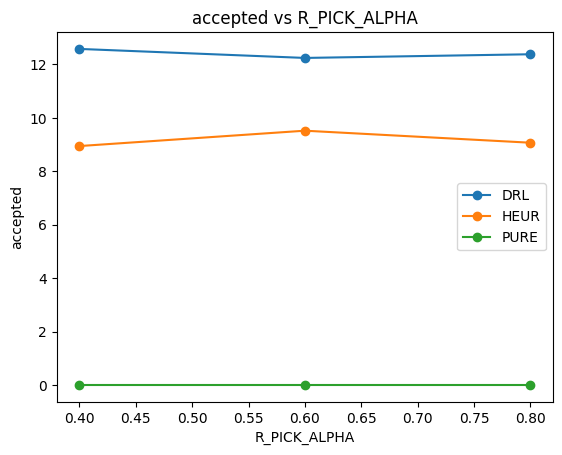

[PLOT] Saved plot_accepted_vs_R_PICK_ALPHA.png


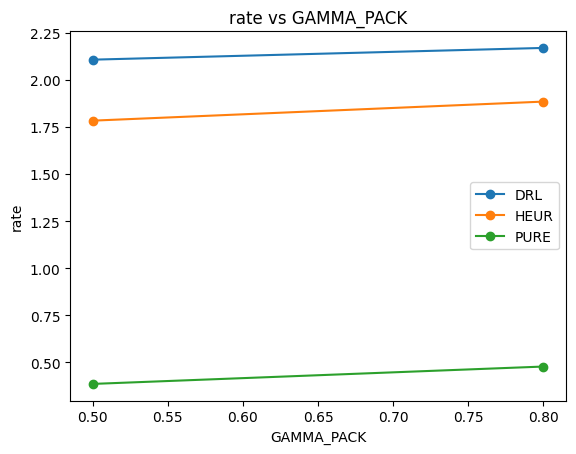

[PLOT] Saved plot_rate_vs_GAMMA_PACK.png


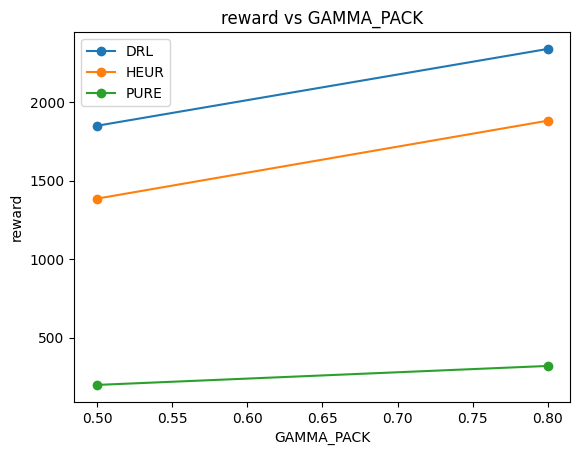

[PLOT] Saved plot_reward_vs_GAMMA_PACK.png


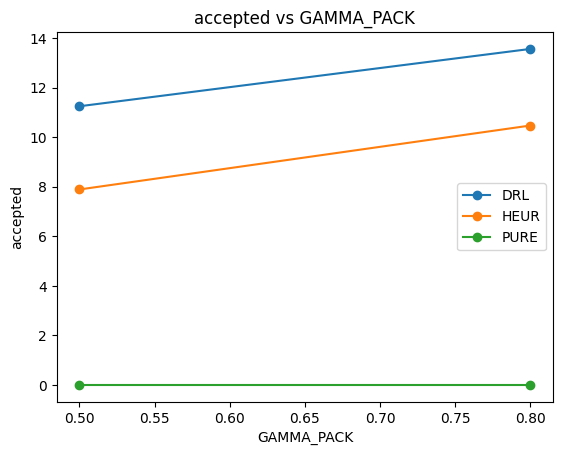

[PLOT] Saved plot_accepted_vs_GAMMA_PACK.png


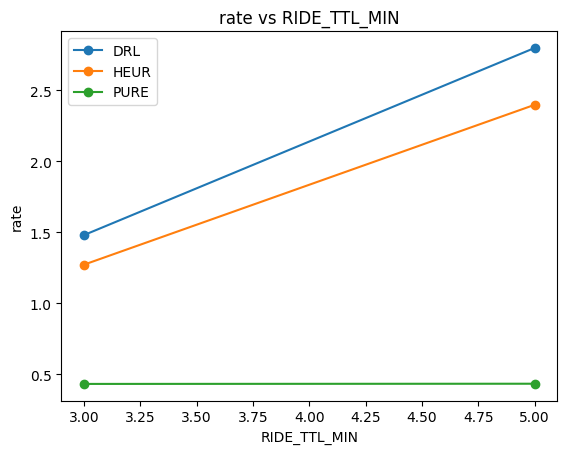

[PLOT] Saved plot_rate_vs_RIDE_TTL_MIN.png


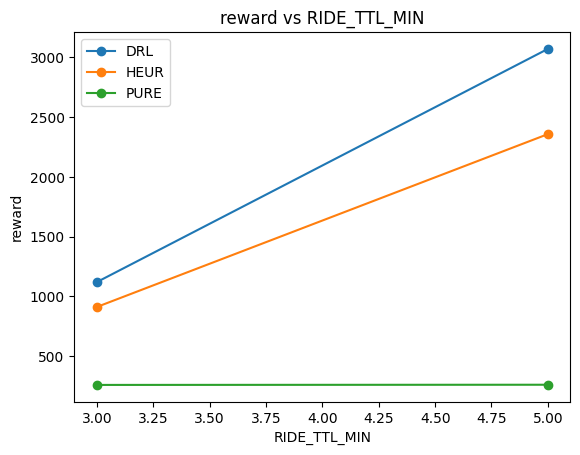

[PLOT] Saved plot_reward_vs_RIDE_TTL_MIN.png


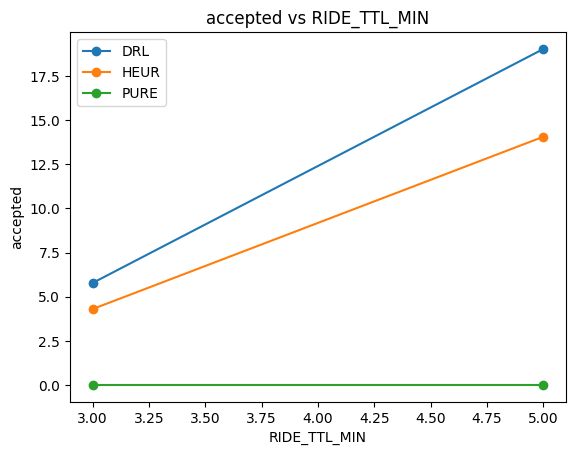

[PLOT] Saved plot_accepted_vs_RIDE_TTL_MIN.png


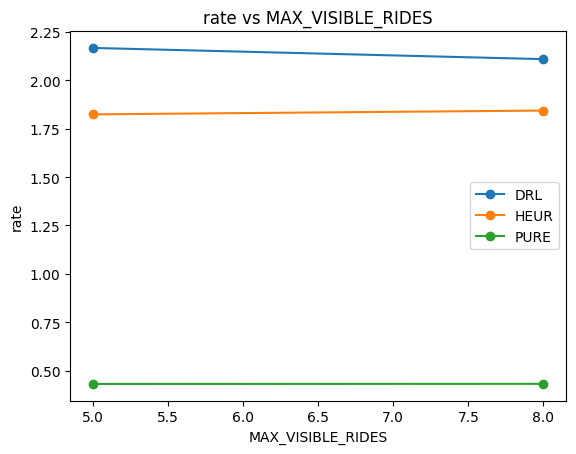

[PLOT] Saved plot_rate_vs_MAX_VISIBLE_RIDES.png


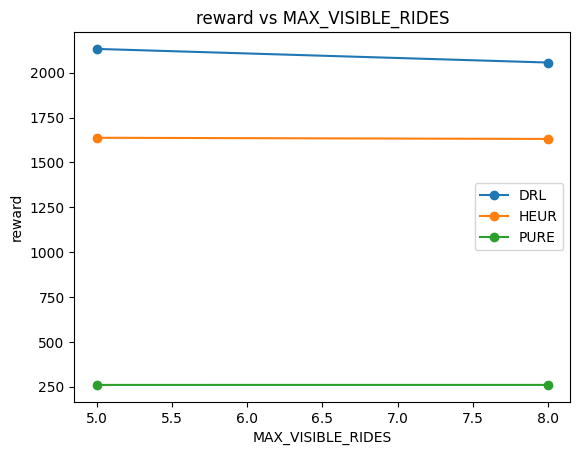

[PLOT] Saved plot_reward_vs_MAX_VISIBLE_RIDES.png


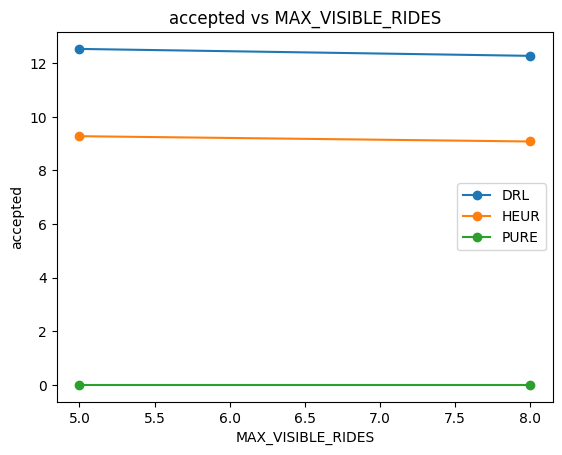

[PLOT] Saved plot_accepted_vs_MAX_VISIBLE_RIDES.png


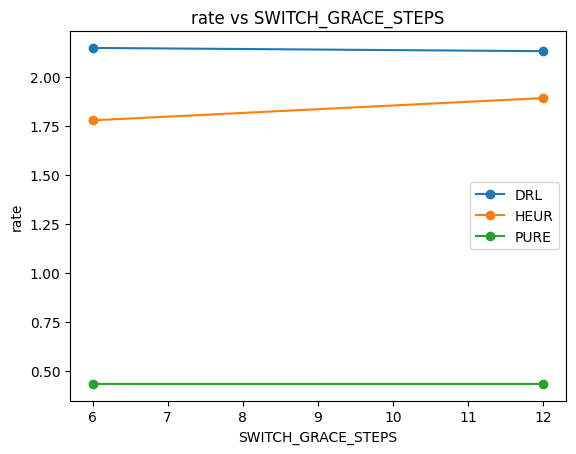

[PLOT] Saved plot_rate_vs_SWITCH_GRACE_STEPS.png


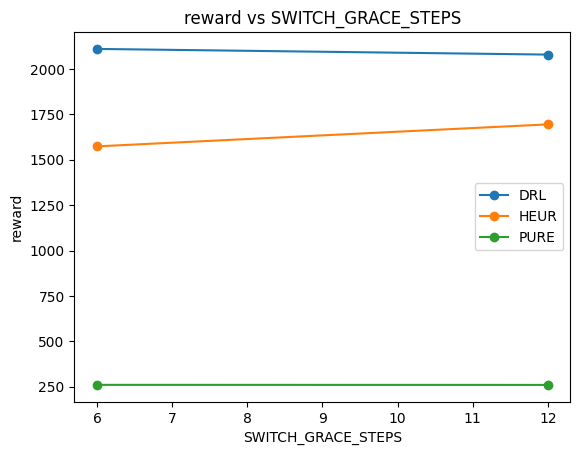

[PLOT] Saved plot_reward_vs_SWITCH_GRACE_STEPS.png


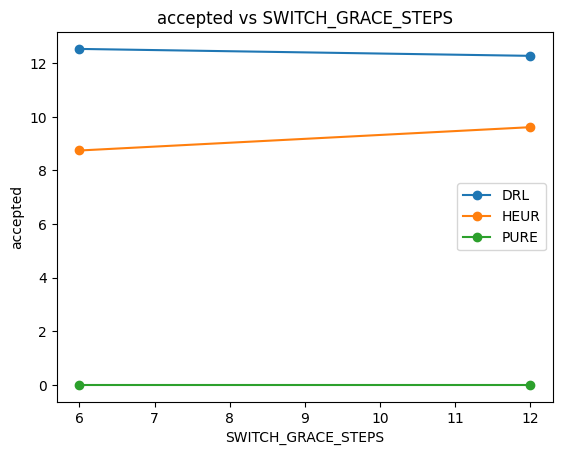

[PLOT] Saved plot_accepted_vs_SWITCH_GRACE_STEPS.png


In [ ]:
LAMBDA_list            = [0.4, 0.6, 0.9]
R_PICK_ALPHA_list      = [0.4, 0.6, 0.8]
GAMMA_PACK_list        = [0.5, 0.8]
RIDE_TTL_MINUTES_list  = [3, 5]
MAX_VISIBLE_RIDES_list = [5, 8]
SWITCH_GRACE_STEPS_list= [6, 12]

CSV_PATH = "param_sweep_results.csv"

df = run_param_sweep(LAMBDA_list,
                     R_PICK_ALPHA_list,
                     GAMMA_PACK_list,
                     RIDE_TTL_MINUTES_list,
                     MAX_VISIBLE_RIDES_list,
                     SWITCH_GRACE_STEPS_list,
                     train_updates_per_combo=50,      # Set to 20~50 for short DRL training. Set to 200 for full training of each parameter combination.
                     csv_path=CSV_PATH,
                     seed_offset=0)

display(df.head(12))
print(f"Saved to {CSV_PATH}")

# Plot single-parameter trend graphs (will be saved as PNG)
plot_from_csv(CSV_PATH,
              vary_keys=["LAMBDA", "R_PICK_ALPHA", "GAMMA_PACK",
                         "RIDE_TTL_MIN", "MAX_VISIBLE_RIDES", "SWITCH_GRACE_STEPS"],
              metrics=("rate", "reward", "accepted"))
